In [1]:
import tensorflow as tf
import tf_keras  # This library handles the legacy model compatibility
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from matplotlib import cm
from IPython.display import display
from PIL import Image

2025-12-07 18:13:16.342348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MODEL_PATH = "/Users/trevorchartier/Documents/Career/School/ECE528/Project/ImitationLearningLaymo/models/006/model.keras"
model = tf_keras.models.load_model(MODEL_PATH)

### Load in Test Images

In [26]:
test_imgs = np.load('../data/processed/test_dataset_initial.npz')['X_data']
test_labels = np.load('../data/processed/test_dataset_initial.npz')['Y_data']

test_labels = test_labels[:,-1] + 1

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf_keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # The gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [30]:
def save_and_display_gradcam(img, heatmap, cam_path="/tmp/cam.jpg", alpha=0.004):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use viridis colormap to colorize heatmap
    viridis = cm.get_cmap("viridis")

    # Use RGB values of the colormap
    viridis_colors = viridis(np.arange(256))[:, :3]
    viridis_heatmap = viridis_colors[heatmap]

    # Create an image with RGB colorized heatmap
    viridis_heatmap = keras.preprocessing.image.array_to_img(viridis_heatmap)
    viridis_heatmap = viridis_heatmap.resize((img.shape[1], img.shape[0]))
    viridis_heatmap = keras.preprocessing.image.img_to_array(viridis_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = viridis_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    return np.array(superimposed_img)


In [31]:
def show_importance(img):
    img_array = np.expand_dims(img, axis=0)
    print(img_array.shape)
    
    # Save original softmax
    last_layer_softmax = model.layers[-1].activation

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    # print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    last_conv_layer_name = 'conv2d_7'
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    return save_and_display_gradcam(img, heatmap)

(1, 60, 80, 3)
1/1 [==============================] - 0s 116ms/step


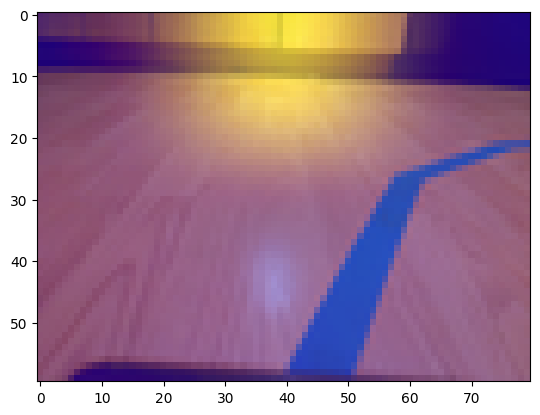

In [39]:
img = show_importance(test_imgs[5])
plt.imshow(img)

## Visualize Heatmaps for Correct vs Incorrect Predictions

In [ ]:
y_pred = np.argmax(model.predict(test_imgs), axis=1)
y_true = test_labels

correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

(1, 60, 80, 3)
1/1 [==============================] - 0s 73ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 61ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 47ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 39ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 30ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 33ms/step


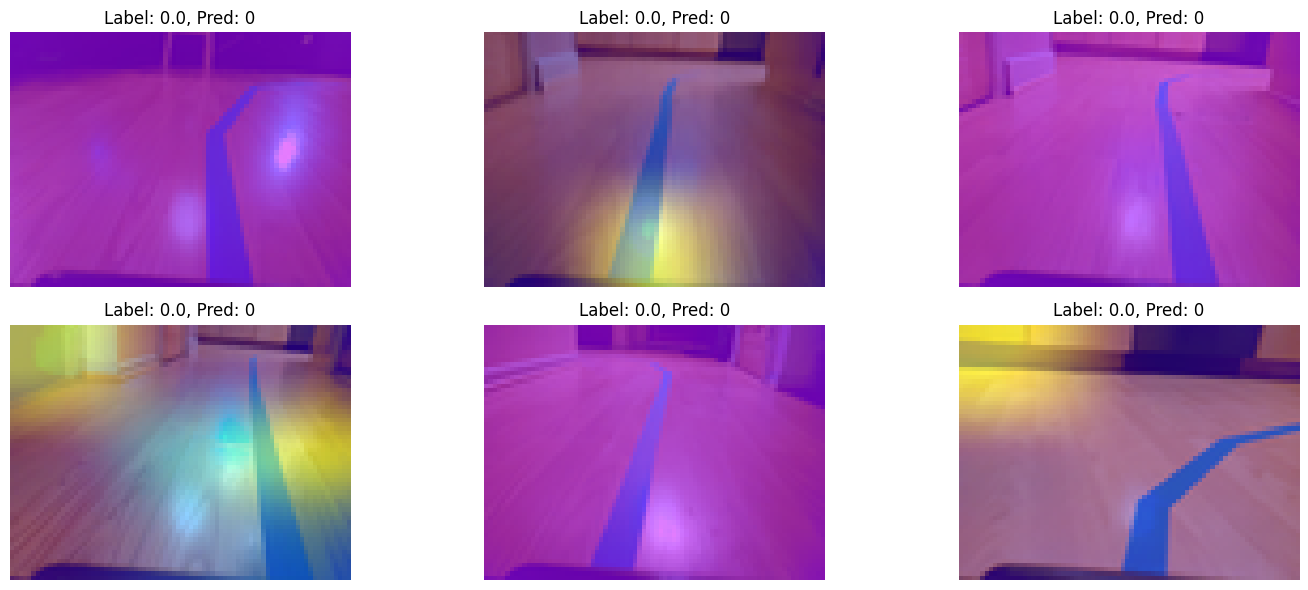

In [45]:
random_correct = np.random.choice(correct_indices, size=6, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_correct): 
    ax = plt.subplot(2, 3, i + 1)
    img = show_importance(test_imgs[idx]);
    plt.imshow(img)
    plt.title(f"Label: {test_labels[idx] - 1}, Pred: {np.argmax(model.predict(test_imgs[idx:idx+1])) - 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

(1, 60, 80, 3)
1/1 [==============================] - 0s 42ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 54ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 32ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 37ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 37ms/step
(1, 60, 80, 3)
1/1 [==============================] - 0s 28ms/step


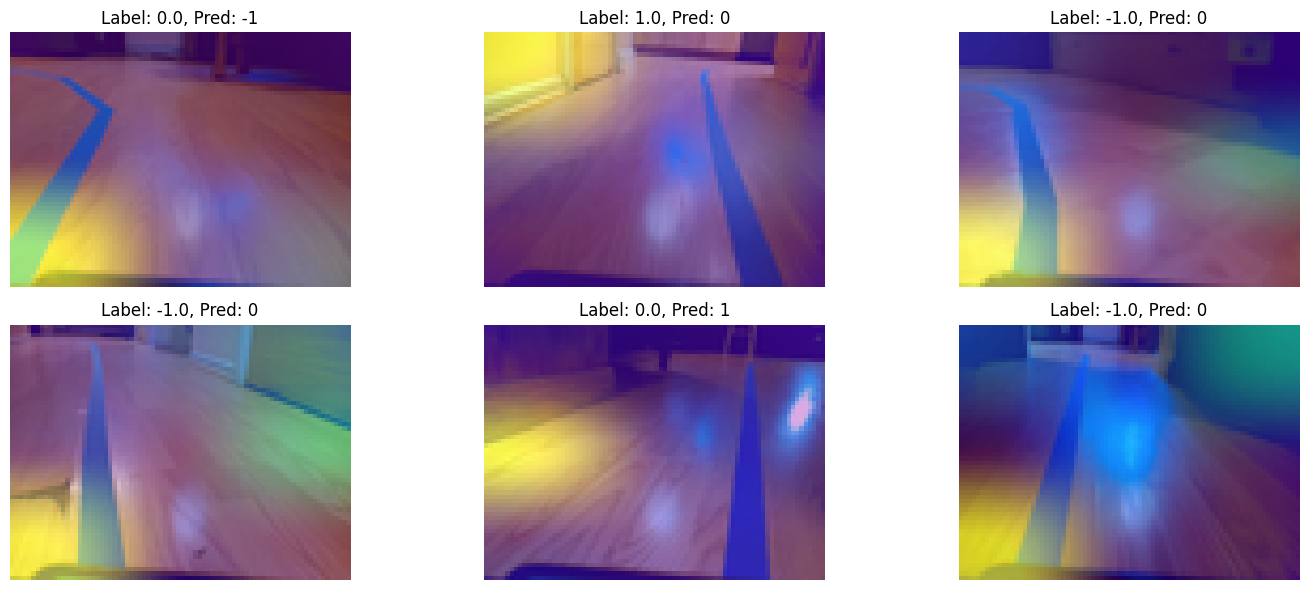

In [46]:
random_incorrect = np.random.choice(incorrect_indices, size=6, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_incorrect):
    ax = plt.subplot(2, 3, i + 1)
    img = show_importance(test_imgs[idx]);
    plt.imshow(img)
    plt.title(f"Label: {test_labels[idx] - 1}, Pred: {np.argmax(model.predict(test_imgs[idx:idx+1])) - 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()